**Ziyi Zhang 1005282720**

# Homework 5: Part I

1. Go get data from kaggle.com and do a ***Bayesian Linear Regression*** analysis

```python
import pymc as pm; import numpy as np
n,p=100,10; X,y=np.zeros((n,p)),np.ones((n,1))
# Replace this made up data with your data set from kaggle...
with pm.Model() as MLR:
    betas = pm.MvNormal('betas', mu=np.zeros((p,1)), cov=np.eye(p), shape=(p,1))
    sigma = pm.TruncatedNormal('sigma', mu=1, sigma=1, lower=0) # half normal
    y = pm.Normal('y', mu=pm.math.dot(X, betas), sigma=sigma, observed=y)

with MLR:
    idata = pm.sample()
```    

2. Choose ***prior*** that are sensible: certainly you might change the ***hyperparameters***, and perhaps you can experiment with different distributional families for `sigma`...

3. [Optional] Assess the performance of the MCMC and note any issues or warnings

    1. Traceplots, inference (credible) intervals, effective sample sizes, energy plots, warnings and other notes... just the usual stuff they do [here](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#pymc-overview)

4. [Optional] Perform ***Multiple Linear Regression*** diagnostics... residual plots, etc.

**Solution:**

The dataset I will be using is called Medical Cost Personal Datasets, and can be accessed using this link: https://www.kaggle.com/datasets/mirichoi0218/insurance

In [1]:
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [2]:
# Load data
data = pd.read_csv('insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Encode the categorical variables and then standarize the numerical data:

In [3]:
# Create a OneHotEncoder object
encoder = OneHotEncoder(sparse=False, drop='first') # drop='first' to avoid multicollinearity

# Select categorical data
categorical_columns = ['sex', 'smoker', 'region']
categorical_data = data[categorical_columns]

# Fit and transform the categorical data
encoded_categorical_data = encoder.fit_transform(categorical_data)

# Create a DataFrame with the encoded variables
encoded_categorical_df = pd.DataFrame(encoded_categorical_data, 
                                      columns=encoder.get_feature_names_out(categorical_columns))

# Select numerical data
numerical_columns = ['age', 'bmi', 'children', 'charges']
numerical_data = data[numerical_columns]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical data
standardized_numerical_data = scaler.fit_transform(numerical_data)

# Create a DataFrame with the standardized variables
standardized_numerical_df = pd.DataFrame(standardized_numerical_data, 
                                         columns=numerical_columns)

# Combine the standardized numerical and encoded categorical data
processed_data = pd.concat([standardized_numerical_df, encoded_categorical_df], axis=1)

# Show the first few rows of the processed data
processed_data.head()

/opt/conda/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,-1.438764,-0.453320,-0.908614,0.298584,0.0,1.0,0.0,0.0,1.0
1,-1.509965,0.509621,-0.078767,-0.953689,1.0,0.0,0.0,1.0,0.0
2,-0.797954,0.383307,1.580926,-0.728675,1.0,0.0,0.0,1.0,0.0
3,-0.441948,-1.305531,-0.908614,0.719843,1.0,0.0,1.0,0.0,0.0
4,-0.513149,-0.292556,-0.908614,-0.776802,1.0,0.0,1.0,0.0,0.0


Now use the processed data for Bayesian linear regression analysis:

In [4]:
# Assigning the standarized and encoded data to X and Y
X = processed_data.drop('charges', axis = 1).values
y = processed_data['charges'].values

with pm.Model() as bayesian_linear_regression:
    
    # Priors for the regression coefficients
    betas = pm.Normal('betas', mu = 0, sigma = 1, shape = X.shape[1])
    
    # Priors for the intercept
    intercept = pm.Normal('intercept', mu = 0, sigma = 1)
    
    # Priors for the error term
    sigma = pm.HalfCauchy('sigma', beta = 1)
    
    # Expected value of outcome (dot product of coefficients and predictiors plus the intercept)
    mu = pm.math.dot(X, betas) + intercept
    
    # Likeluhood (sampling distribution) of observations
    y_obs = pm.Normal('y_obs', mu = mu, sigma = sigma, observed = y)

with bayesian_linear_regression:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, intercept, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

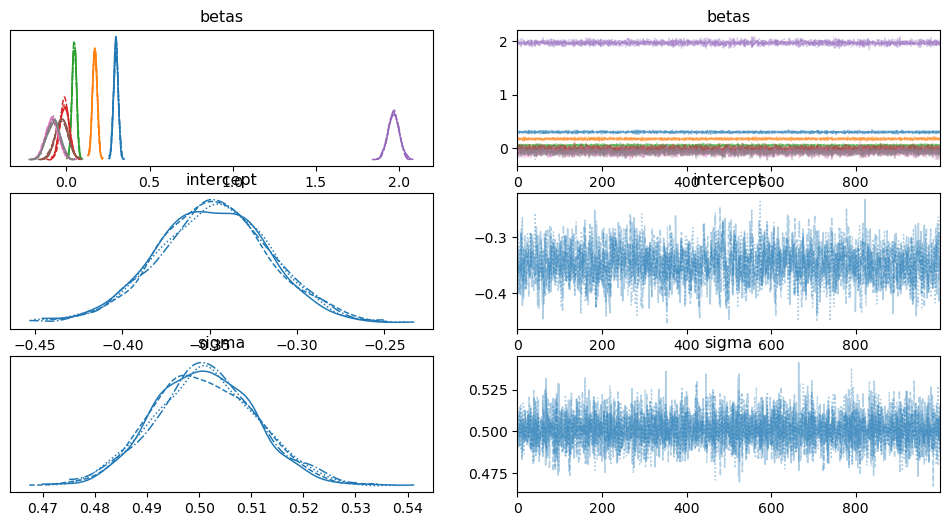

In [5]:
# Inspect the results
az.plot_trace(idata)

# Homework 5: Part II
    
## Answer the following with respect to $p(\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y})$ on the previous slide
    
1. Rewrite $p(\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y})$ in terms of $\sigma^2$ (no longer using $\Sigma$) if $\Sigma=\sigma^2I$

2. What is $E[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}]$?

3. What ***hyperparameters*** values (legal or illegal) would make $E[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}] = (\mathbf{X^\top X})^{-1}\mathbf{X^\top y}$?

4. What ***hyperparameters*** values (legal or illegal) would make $E[  \mathbf{\hat y} = \mathbf{X}\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}] = \mathbf{X}(\mathbf{X^\top X})^{-1}\mathbf{X^\top y}$?

5. What is $\text{Var}[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}]$?

**Solution:**

For the coefficients $\boldsymbol\beta$, we might start with a multivariate normal prior, where $\boldsymbol{\beta}_{0}$ is the mean vector of the prior, and the $\boldsymbol{\Sigma}_{\beta}$ is the covariance matrix: 

$\boldsymbol\beta \sim \mathcal{MVN}(E[\boldsymbol{\beta}] = \boldsymbol{\beta}_{0}, Cov[\boldsymbol{\beta}] = \boldsymbol{\Sigma}_{\beta})$

The likelihood function given the data $\mathbf{X}$ (design matrix) and $\mathbf{y}$ (response vector) is typically assumed to be normal as well, and where $\sigma^2$ is the variance of the error terms: 

$\mathbf{y}_{nx1} \sim \mathcal{MVN}(\mathbf{X}_{nxp}\boldsymbol{\beta}_{px1}, \boldsymbol{\Sigma}_{nxn} = \sigma^2I_{nxn})$

$\begin{align*}
p(\mathbf{y} | \boldsymbol \beta, \boldsymbol \Sigma, \mathbf{X})= {}& (2\pi )^{-n/2}\det({\boldsymbol {\Sigma }})^{-1/2}\,\exp \left(-{\frac {1}{2}}(\mathbf {y} -\mathbf{X\beta})^\top{\boldsymbol {\Sigma }}^{-1}(\mathbf{y} - \mathbf{X\beta})\right)\\
\propto{}& \exp\left(\mathbf{\beta}^\top\mathbf{X}^\top\boldsymbol\Sigma^{-1}\mathbf{y} - \frac{1}{2}\mathbf{\beta}^\top \mathbf{X}^\top \boldsymbol\Sigma^{-1} \mathbf{X\beta} \right)\\
\propto{}& \exp\left( - \frac{1}{2} \left( \beta - (\mathbf{X}^\top \boldsymbol\Sigma^{-1} \mathbf{X})^{-1}\mathbf{X}^\top \boldsymbol\Sigma^{-1}\mathbf{y}\right)^{\!\top} \left[\mathbf{X}^{\top} \boldsymbol\Sigma^{-1} \mathbf{X} \right]\left( \beta - (\mathbf{X}^\top \boldsymbol\Sigma^{-1} \mathbf{X})^{-1}\mathbf{X}^\top \boldsymbol\Sigma^{-1}\mathbf{y}\right)  \right)\\
\end{align*}$

The posterior distribution of $\boldsymbol{\beta}$ given $\boldsymbol{\Sigma}, \mathbf{X}, \mathbf{y}$ combines the prior distribution with the likelihood of th eobserved data, which, in the case of a conjugate prior, is like a normal distribution:

$p(\boldsymbol{\beta}|\boldsymbol\Sigma, \mathbf{X}, \mathbf{y}) \propto p(\mathbf{y} | \mathbf{X}, \boldsymbol\beta)p(\boldsymbol\beta)$

$\begin{align*}
p(\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}) = {}& \mathcal{MVN}\left(\overset{E[\boldsymbol \beta | \boldsymbol\Sigma, \mathbf{X},\mathbf{y}] \; = \quad\quad}{\text{Cov}[\boldsymbol \beta | \boldsymbol\Sigma, \mathbf{X},\mathbf{y}]}\bigg( \mathbf{X}^\top \boldsymbol\Sigma^{-1}\mathbf{y} + \boldsymbol \Sigma_\beta^{-1}\boldsymbol\beta_0 \right), \text{Cov}[\boldsymbol \beta | \boldsymbol\Sigma, \mathbf{X},\mathbf{y}] = \left[\mathbf{X}^{\top}\boldsymbol \Sigma^{-1} \mathbf{X}  + \boldsymbol \Sigma_\beta^{-1} \right]^{-1} \bigg)\\
\end{align*}$

where
$E[\boldsymbol \beta | \boldsymbol\Sigma, \mathbf{X},\mathbf{y}] = [\mathbf{X}^{T}\boldsymbol\Sigma^{-1}\mathbf{X} + \boldsymbol{\Sigma_{\beta}}^{-1})^{-1}(\mathbf{X}^{T} \boldsymbol\Sigma^{-1}\mathbf{y} + \boldsymbol \Sigma_\beta^{-1}\boldsymbol\beta_0]$, 
and
$\text{Cov}[\boldsymbol \beta | \boldsymbol\Sigma, \mathbf{X},\mathbf{y}] = \left[\mathbf{X}^{\top}\boldsymbol \Sigma^{-1} \mathbf{X}  + \boldsymbol \Sigma_\beta^{-1} \right]^{-1}$


1. Rewrite $p(\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y})$ in terms of $\sigma^2$

    Once we replace $\boldsymbol{\Sigma} = \sigma^2I$, the expression simplify to:
    
    $E[\boldsymbol \beta | \sigma^2I, \mathbf{X},\mathbf{y}] = [\mathbf{X}^{T}(\sigma^2I)^{-1}\mathbf{X} + \boldsymbol{\Sigma_{\beta}}^{-1})^{-1}(\mathbf{X}^{T} (\sigma^2I)^{-1}\mathbf{y} + \boldsymbol \Sigma_\beta^{-1}\boldsymbol\beta_0]$
    $\text{Cov}[\boldsymbol \beta | \sigma^2I, \mathbf{X},\mathbf{y}] = \left[\mathbf{X}^{T}(\sigma^2I)^{-1} \mathbf{X}  + \boldsymbol \Sigma_\beta^{-1} \right]^{-1}$
    
    Since $\boldsymbol{\Sigma} = \sigma^2I$, the distribution of $\boldsymbol{\beta}$ given $\mathbf{X}$ and $\mathbf{y}$ can be rewritten by substituting $\boldsymbol{\Sigma}$ with $\sigma^2I$ in the normal distribution's density function. If $\boldsymbol{\Sigma} = \sigma^2I$, the prior covariance matrix is proportional to the identity matrix, scaled by $\sigma^2$. The inverse of this matrix is $\boldsymbol{\Sigma}^{-1} = \frac{1}{\sigma^2}I$, and the determinant is $|\boldsymbol{\Sigma}| = (\sigma^2)^{n}$ if $\boldsymbol{\Sigma}$ is an $n * n $ matrix. We can further simplify by assuming that $\boldsymbol{\Sigma}_{\beta}$ is also a scalar times the identity matrix (which is equivalent to the prior belief that all elements of $\beta$ are iid), the expression simplify as the inverse of a scalar times the identity matrix is just the reciprocal of the scalar times the identity matrix. 
    
    In that case, the posterior distribution is given by:
    
    $p(\boldsymbol \beta |\sigma^2I, \mathbf{X},\mathbf{y}) = \mathcal{MVN}\bigg(E[\boldsymbol \beta | \sigma^2I, \mathbf{X},\mathbf{y}] = [\mathbf{X}^{T}\mathbf{X} + \sigma^2\boldsymbol{\Sigma_{\beta}}^{-1}]^{-1}[\mathbf{X}^{T}\mathbf{y} + \sigma^2\boldsymbol \Sigma_\beta^{-1}\boldsymbol\beta_0], \text{Cov}[\boldsymbol \beta | \sigma^2I, \mathbf{X},\mathbf{y}] = \left[\mathbf{X}^{T}\mathbf{X}  + \sigma^2\boldsymbol \Sigma_\beta^{-1} \right]^{-1} \bigg)$
    

2. What is $E[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}]$

    The expectation $E[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}]$ represents the expected value of the coefficients $\beta$ given the data $\mathbf{X}$, the response $\mathbf{y}$, and the covariance matrix $\boldsymbol\Sigma$. Based on the slide, this is given by:
    
    $E[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}] = (\mathbf{X}^{T}\boldsymbol\Sigma^{-1}\mathbf{X})^{-1}\mathbf{X}^{T}\boldsymbol\Sigma^{-1}\mathbf{y}$
    

3. What hyperparameters values (legal or illegal) would make $E[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}] = (\mathbf{X^\top X})^{-1}\mathbf{X^\top y}$

    To make $E[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}]$ equal to $(\mathbf{X^\top X})^{-1}\mathbf{X^\top y}$, we would need the prior covariance matrix $\boldsymbol\Sigma$ to be proportional to the identity matrix $\mathbf{I}$, effectively making the prior uninformative. This would lead to the standard ordianry lease squares (OLS) solution. This can be achieved with $\boldsymbol\Sigma \propto \mathbf{I}$ or more simply when $\boldsymbol\Sigma$ becomes very large (approaching improper prior)

4. What hyperparameters values (legal or illegal) would make $E[  \mathbf{\hat y} = \mathbf{X}\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}] = \mathbf{X}(\mathbf{X^\top X})^{-1}\mathbf{X^\top y}$

    For $E[  \mathbf{\hat y} = \mathbf{X}\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}]$ to equal $\mathbf{X}(\mathbf{X^\top X})^{-1}\mathbf{X^\top y}$, we would use the same condistions as in the previous question since $\mathbf{\hat y} = \mathbf{X}\boldsymbol \beta$. Hence, the same hyperparameters that make the expected value of $\boldsymbol\beta$ equivalent to the OLS estimate will also make the expected value of $\mathbf{\hat y}$ equivalent to the OLS prediction.

5. What is $\text{Var}[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}]$

    The variance of $\boldsymbol \beta$ given $\boldsymbol\Sigma, \mathbf{X},\mathbf{y}$ is:
    
    $\text{Var}[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}] = (\mathbf{X}^{T}\boldsymbol\Sigma^{-1}\mathbf{X})^{-1}$

# Homework 5: Part III

1. Go get data from kaggle.com and perform inference for a ***Bayesian Multivariate Normal Model***

<SPAN STYLE="font-size:12.0pt">

```python
import numpy as np; from scipy import stats
p=10; Psi=np.eye(p); a_cov = stats.invwishart(df=p+2, scale=Psi).rvs(1)
n=1000; y=stats.multivariate_normal(mean=np.zeros(p), cov=a_cov).rvs(size=n)
# Replace this made up data with your data set from kaggle...
    
with pm.Model() as MNV_LKJ:
    packed_L = pm.LKJCholeskyCov("packed_L", n=p, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=2), compute_corr=False)
    L = pm.expand_packed_triangular(p, packed_L)
    # Sigma = pm.Deterministic('Sigma', L.dot(L.T)) # Don't use a covariance matrix parameterization
    mu = pm.MvNormal('mu', mu=np.array(0), cov=np.eye(p), shape=p); 
    # y = pm.MvNormal('y', mu=mu, cov=Sigma, shape=(n,1), observed=y) 
    # Figure out how to parameterize this with a Cholesky factor to improve computational efficiency 
with MNV_LKJ    
    idata = pm.sample()
```    
</SPAN>

2. As indicated above, don't use a covariance matrix parameterization and instead figure out how to parameterize this with a ***Cholesky factor*** to improve computational efficiency. The ***Cholesky***-based formulation allows general $O(n^3)$ $\det({\boldsymbol \Sigma})$ to be computed using a simple $O(n)$ product and general $O(n^3)$ ${\boldsymbol \Sigma}^{-1}$ to be instead evaluated with $O(n^2)$ ***backward substitution***. 

2. Specify ***priors*** that work: certainly you'll likely need to change the ***prior hyperparameters*** for $\boldsymbol \mu$ (`mu`) and $\mathbf{R}$ (`packed_L`)...
    1. And you could consider adjusting the ***prior*** for $\boldsymbol \sigma$ using `sd_dist`... 

3. [Optional] Assess the performance of the MCMC and note any issues

    1. Traceplots, inference (credible) intervals, effective sample sizes, energy plots, warnings and other notes... just the usual stuff they do [here](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#pymc-overview)

**Solution:**

Using the same Medical Cost Personal Datasets as Part I homework, it can be accessed using this link: https://www.kaggle.com/datasets/mirichoi0218/insurance

In [6]:
# Show the first few rows of the processed data
processed_data.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,-1.438764,-0.453320,-0.908614,0.298584,0.0,1.0,0.0,0.0,1.0
1,-1.509965,0.509621,-0.078767,-0.953689,1.0,0.0,0.0,1.0,0.0
2,-0.797954,0.383307,1.580926,-0.728675,1.0,0.0,0.0,1.0,0.0
3,-0.441948,-1.305531,-0.908614,0.719843,1.0,0.0,1.0,0.0,0.0
4,-0.513149,-0.292556,-0.908614,-0.776802,1.0,0.0,1.0,0.0,0.0


In [7]:
# Setting up the Bayesian model using the actual data
with pm.Model() as MNV_LKJ:
    
    # Define the priors for the Cholesky decomposed covariance matrix
    eta = 2.0 # The eta parameter controls the distribution of the eigenvalues of the correlation matrix
    sd_dist = pm.Exponential.dist(1.0)
    packed_L = pm.LKJCholeskyCov('packed_L', n = processed_data.shape[1], eta = eta, sd_dist = sd_dist, compute_corr = False)
    L = pm.expand_packed_triangular(processed_data.shape[1], packed_L, lower = True)
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    
    # Set up the multivariate normal distribution
    mu = pm.MvNormal('mu', mu = np.array(0), cov = np.eye(processed_data.shape[1]), shape = processed_data.shape[1])
    y = pm.MvNormal('y', mu = mu, cov = Sigma, observed = processed_data.values)
    
with MNV_LKJ:
    idata = pm.sample()
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 314 seconds.


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'packed_L'}>,
        <Axes: title={'center': 'packed_L'}>],
       [<Axes: title={'center': 'Sigma'}>,
        <Axes: title={'center': 'Sigma'}>]], dtype=object)

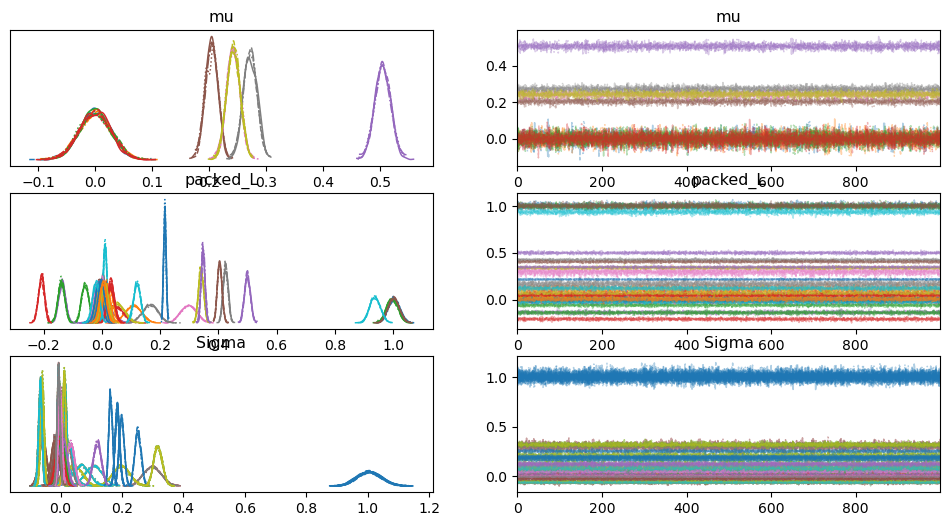

In [8]:
# Inspect the results
az.plot_trace(idata)